# Forecasting Daily Metro Users

## Importing Data and Libraries 

In [85]:
# Usual imports
import sys
import os

sys.path.append("../src")

import importlib

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import cufflinks

cufflinks.go_offline()

from pmdarima.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings

warnings.filterwarnings("ignore")

from visualize import plot_seasonal_decompose, tsplot

## Total Node - Univariate Time Series Models

I will start by forecasting total series, that is, what would be the top node in our hierarchy. By doing that, I will demonstrate how I approach a time series problem a univariate scenario with a few different models. Then, I will use HTS concepts to build models in a hierarchical way, considering different reconciliation approaches, such as Top-Down, Bottom-Up and OLS implemented by scikit-hts library.

In [75]:
df_hier = (
    pd.read_csv('../data/preprocessed/turnstiles_hierarchical_data.csv', parse_dates=['time'])
      .set_index('time')
      .loc['2010-06-30':'2017-08-31']
)

df_hier.tail(5)

,Brooklyn_53 ST,Brooklyn_55 ST,Brooklyn_8 AV,Brooklyn_ALABAMA AV,Brooklyn_CARROLL ST,Brooklyn_CYPRESS HILLS,Brooklyn_DEKALB AV,Brooklyn_GRANT AV,Brooklyn_GREENPOINT AV,Brooklyn_LIBERTY AV,...,The Bronx_BAYCHESTER AV,The Bronx_BRONX PARK EAST,The Bronx_HUNTS POINT AV,The Bronx_LONGWOOD AV,The Bronx_ZEREGA AV,Manhattan,Brooklyn,Queens,The Bronx,total
time,,,,,,,,,,,,,,,,,,,,,
2017-04-30,0.0,49461.0,1027578.0,63958.0,296592.0,34106.0,787166.0,160592.0,242479.0,73281.0,...,80858.0,67337.0,263773.0,92621.0,66052.0,1228712.0,4164385.0,1171455.0,1181091.0,7745643.0
2017-05-31,0.0,53721.0,1060753.0,70171.0,324374.0,40116.0,796885.0,170719.0,239041.0,81665.0,...,93576.0,77160.0,288343.0,100691.0,73540.0,1232958.0,4318112.0,1324572.0,1297788.0,8173430.0
2017-06-30,0.0,53400.0,1022668.0,67137.0,312997.0,34749.0,819700.0,170235.0,231267.0,76449.0,...,89177.0,72005.0,280372.0,96459.0,70157.0,1240071.0,4235297.0,1244326.0,1239982.0,7959676.0
2017-07-31,0.0,46047.0,991017.0,64830.0,260628.0,36114.0,794891.0,159063.0,239033.0,68100.0,...,71633.0,62247.0,259844.0,86462.0,64066.0,1134033.0,4013743.0,1004953.0,1131276.0,7284005.0
2017-08-31,0.0,50686.0,988180.0,66445.0,267699.0,36088.0,817439.0,164294.0,247166.0,71796.0,...,80692.0,60135.0,268347.0,88899.0,65645.0,1197786.0,4087050.0,1084816.0,1161259.0,7530911.0


<AxesSubplot:xlabel='time'>

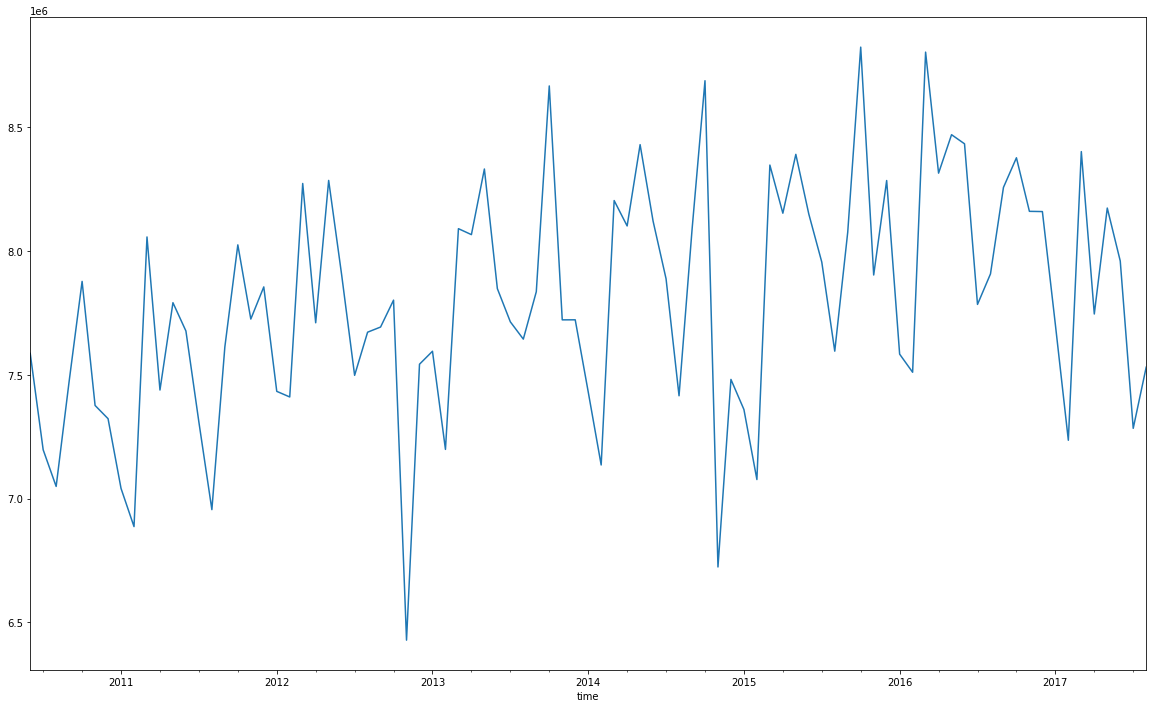

In [76]:
df_total = df_hier['total'].copy()
df_total.plot(figsize=(20, 12))

## Train-Test split

The first thing we need to do and one of the most important ones is to divide data into train/test splits so we can assess properly performance of our models. For me, even data relating to images and text need to have a validation strategy based on temporal factos, imagine when we are dealing with **time** series.

In [77]:
train_total, test_total = train_test_split(df_total, test_size=0.2)

train_total.shape, test_total.shape

((69,), (18,))

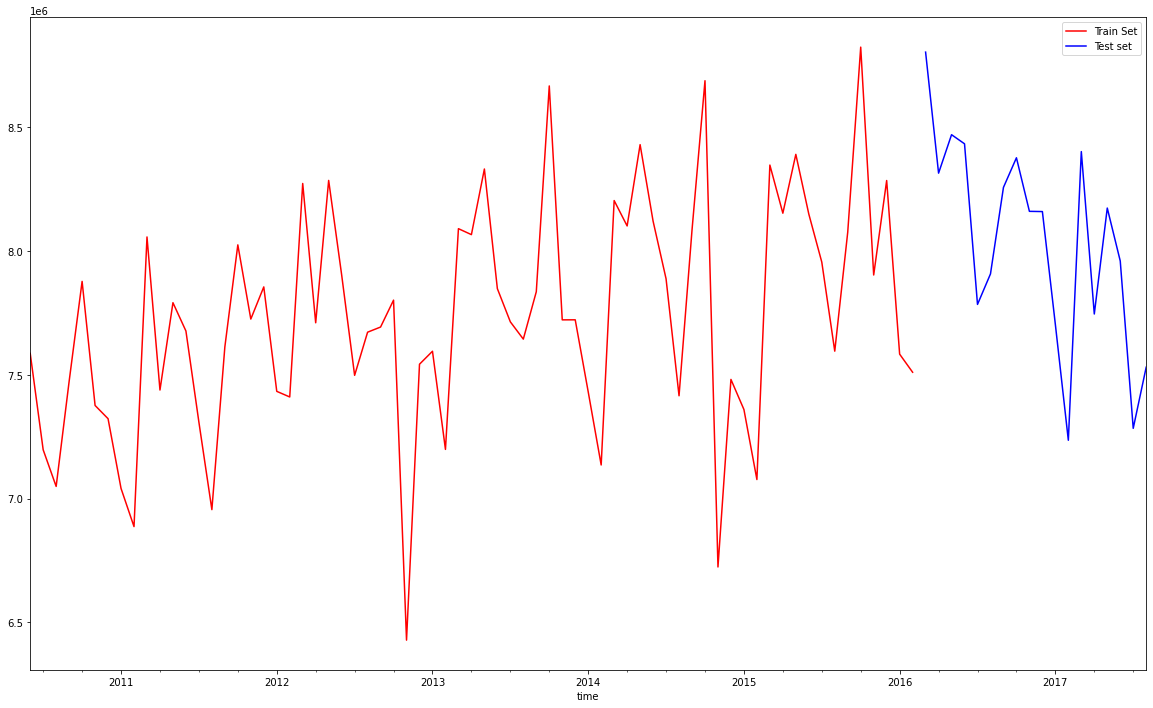

In [78]:
train_total.plot(figsize=(20, 12), color='r', label="Train Set")
ax = test_total.plot(color='b', label="Test set")

ax.legend();

## Baseline and Cross-Validation

Besides train-test split, we have to overcome problems related to overfitting, that is, when variance diminishes in a level that the model is just memorizing its train values. When dealing with temporal data, we have two main types of cross-validation other than folds? Window and Rolling CV methods.

Moreover, time series it is a field of study where a lot of fancy models can't beat simple naive methods, such as using last values, or last seasonal values as forecasts. We also have even white noise series that are cannot be predicted at all. Therefore, when building each model, I will compare results using relevant metrics with baselines and cross-validation if possible. 

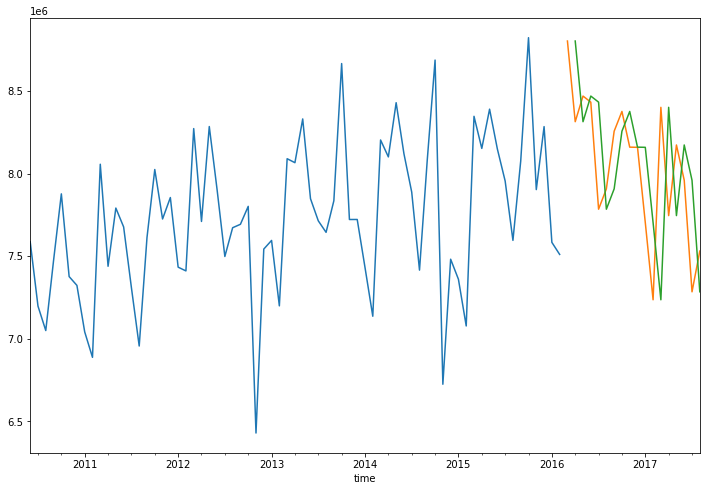

In [148]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.utils.plotting.forecasting import plot_ys

y_train = train_total.reset_index(drop=True)
y_test = test_total.reset_index(drop=True)

forecaster_last = NaiveForecaster(strategy='last')

def train_and_print(forecaster, seasonal=False):
    forecaster.fit(y_train)

    cv = SlidingWindowSplitter(fh=1)
    
    if seasonal:
        y_pred = forecaster.update_predict(pd.concat([y_train, y_test]).reset_index(drop=True), cv)[-test_total.shape[0]:]
    else:
        y_pred = forecaster.update_predict(y_test, cv)
                                           
    fig, ax = plt.subplots(figsize=(12, 8))

    train_total.plot(ax=ax)
    test_total.plot(ax=ax)

    y_pred.index = test_total.index
    y_pred.plot(ax=ax)
    
    return y_pred
    
y_pred_last_naive = train_and_print(forecaster_last)

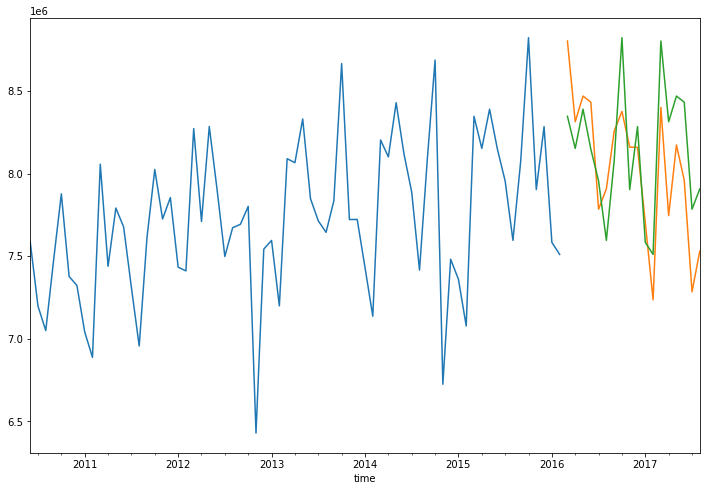

In [149]:
forecaster_seasonal_last = NaiveForecaster(strategy="seasonal_last", sp=12)
y_pred_seasonal_naive = train_and_print(forecaster_seasonal_last, seasonal=True)

In [160]:
from sktime.performance_metrics.forecasting import smape_loss

def print_metrics(y_test, y_pred, y_train=None):
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print(f"SMAPE: {smape_loss(y_test, y_pred)}")
    
print_metrics(y_test, y_pred_last_naive.fillna(y_train.values[-1]).reset_index(drop=True))

MAE: 430009.6666666667
RMSE: 553541.8010093427
SMAPE: 0.053921532329117006


In [163]:
print_metrics(y_test, y_pred_seasonal_naive.reset_index(drop=True))

MAE: 304690.8333333333
RMSE: 336633.41625564214
SMAPE: 0.03770400082920999


As expected, results for last naive model were better than simple last value. Basically, from MTA management position, by doing naive seasonal forecasts, they are off 300,000 users by month. Since this series level is around 6-8 million users, it is around 3% of error, not all bad for a just basic approach. Basically, our models need to beat that.

## Statistical Properties of time series data

### Series Decomposition

We can assume a time series to have three main componentes: Seasonal, Trend-Cycle and Residuals. Using this simple model, we can visualize the three plots to understand / infer data structure.

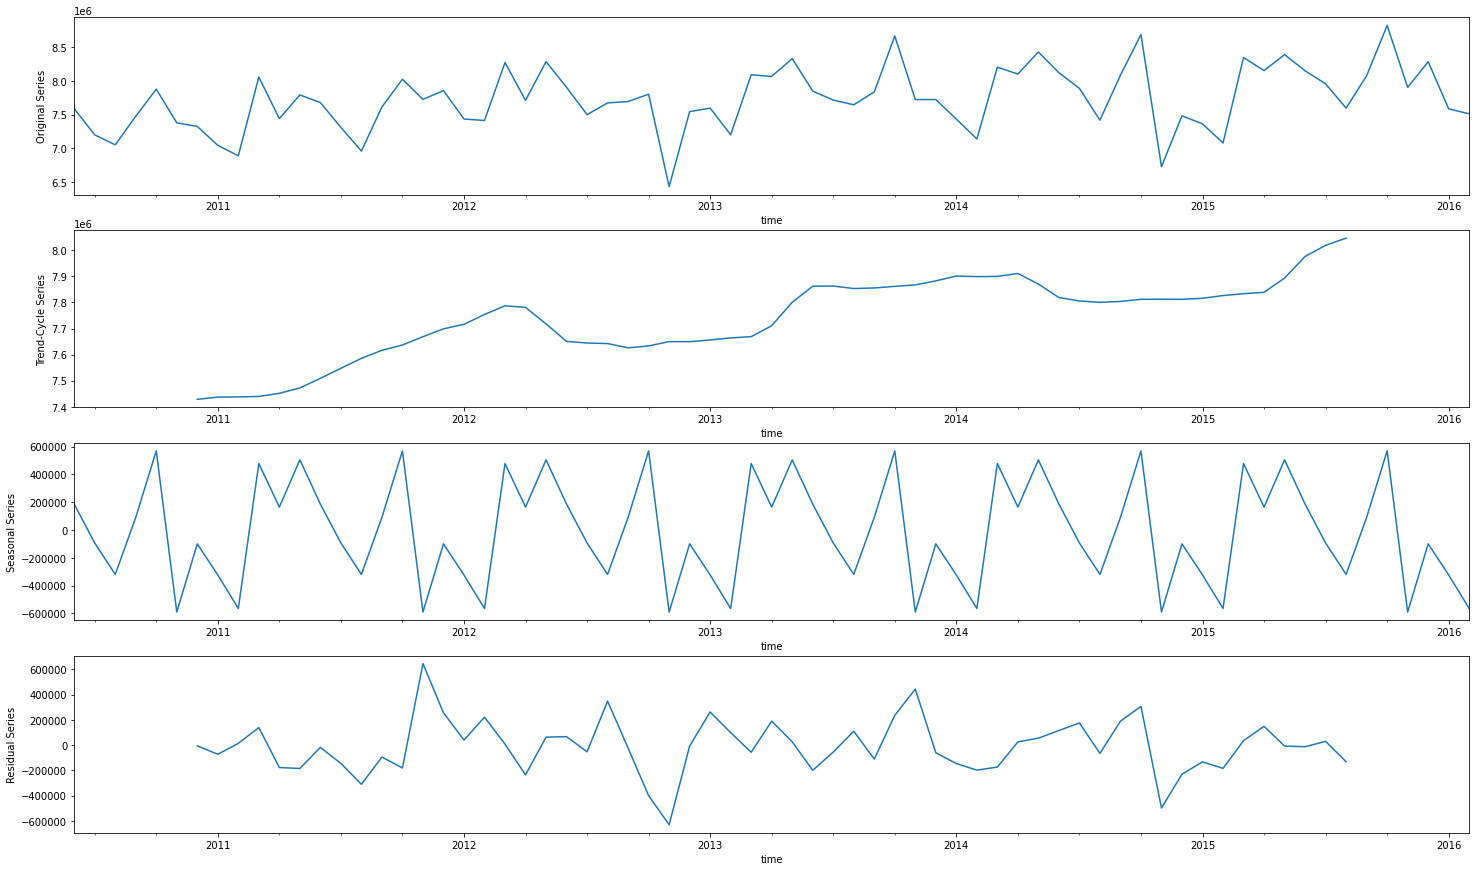

In [80]:
total_decomposed = plot_seasonal_decompose(train_total)

Trend-Cycle series shows us that total number of users is increasing (at least in this sampled stations). Seasonal decomposition shows us peaks around May-July and November as discussed in EDA notebooks.

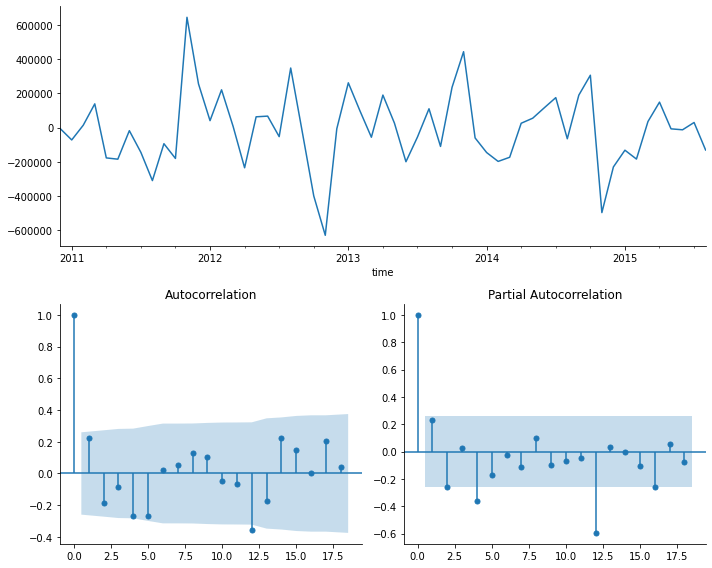

In [81]:
tsplot(total_decomposed.resid.dropna());

Autocorrelation and Partial autocorrelation plots for residuals in this simple decomposition shows us that we have still information to extract from data, so a simple model like that is not enough.

#### PACF and ACF plots

ACF and PACF plots are used to understand how the series is correlated with its past values. It is an excellent technique to see if a series can be predicted or if it is just white noise.

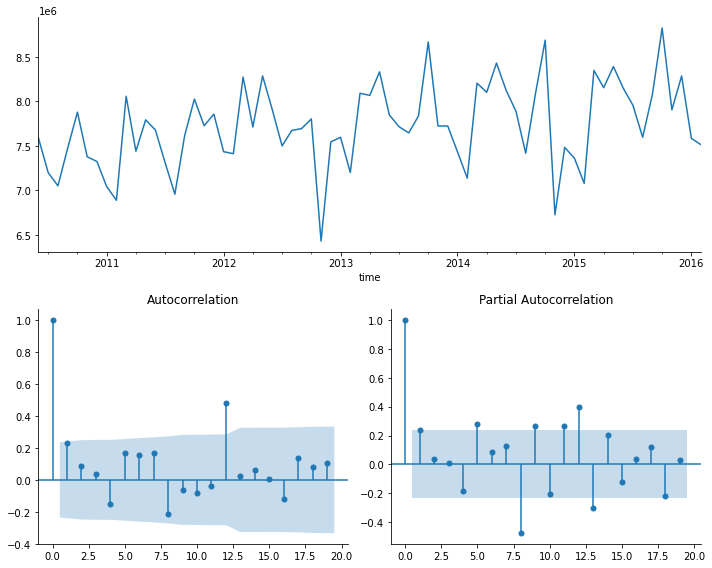

In [82]:
tsplot(train_total);

We can see that with have significant levels in both ACF and PACF plots. This demonstrates that we have patterns in our data that we can extract. I will talk more about it when dealing with ARIMA and AutoArima models.

### Holt-Winters

Let's start with exponential family models. They are one of the simplest and most used models applied to time series expet maybe the naive ones we will discuss later. Basically, it is a model based on a weighted average of past values where we have a decreasing exponential factors for lags in distant past. I will not introduce any theory here, you can read more at [Hyndman's website](https://otexts.com/fpp2/hierarchical.html)

The most basic form has even its own function in pandas, so we can visualize it for different alpha parameters.

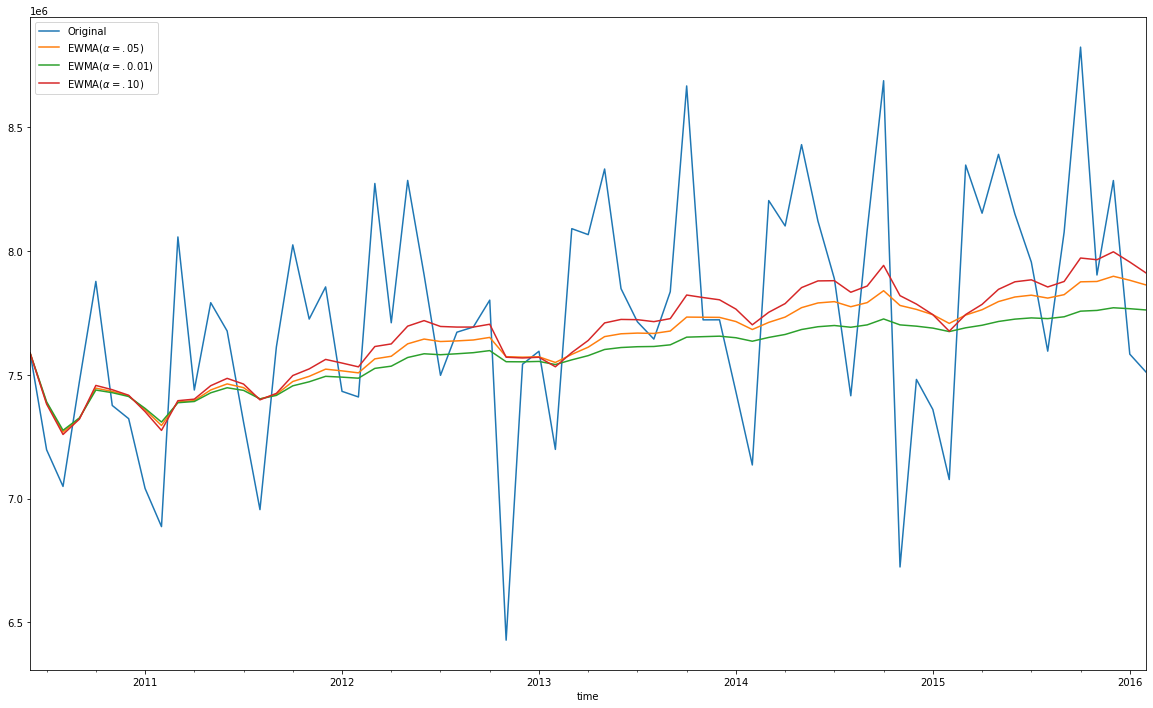

In [84]:
fig, ax = plt.subplots(figsize=(20, 12))

train_total.plot(ax=ax, label='Original')
train_total.ewm(alpha=0.05).mean().plot(ax=ax, label='EWMA($\\alpha=.05$)')
train_total.ewm(alpha=0.01).mean().plot(ax=ax, label='EWMA($\\alpha=.0.01$)')
train_total.ewm(alpha=0.1).mean().plot(ax=ax, label='EWMA($\\alpha=.10$)')


ax.legend()

Alpha parameter controls how 'well' the series remember itself, that is, if it will base the next forecast observations on long past values or the closes ones. Let's fit a complete Holt-Winter model using statsmodels.

In [168]:
clf_holt = ExponentialSmoothing(endog=train_total, 
                                trend="add",
                                damped=True,
                                seasonal="additive", 
                                seasonal_periods=12).fit(optimized=True)

clf_holt.model.params

{'smoothing_level': 0.05263157894736654,
 'smoothing_slope': 0.05263157894736842,
 'smoothing_seasonal': 0.15789473684209962,
 'damping_slope': 0.9473684210526334,
 'initial_level': 7880941.833333282,
 'initial_slope': 22030.673611114595,
 'initial_seasons': array([-294166.83333332, -683636.83333333, -831552.83333336,
        -407413.83333333,   -3659.83333332, -504622.83333339,
        -558034.83333333, -839670.83333333, -993783.83333336,
         175808.16666664, -442254.83333335,  -89636.83333336]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

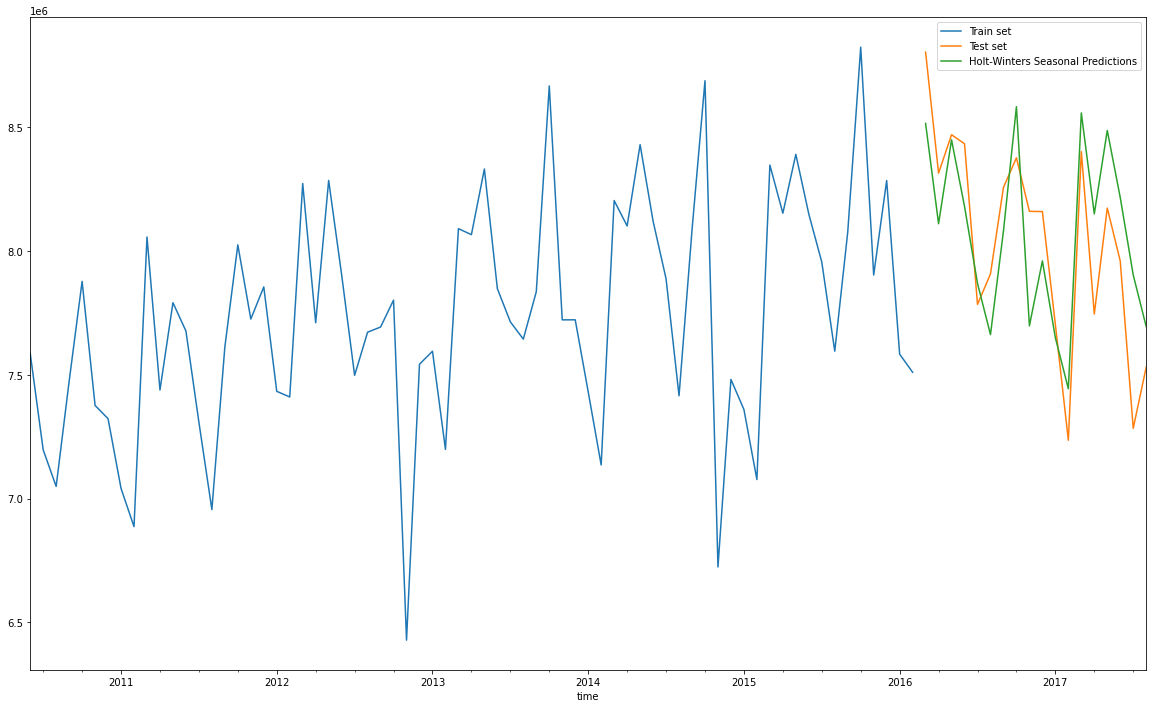

In [169]:
fig, ax = plt.subplots(figsize=(20, 12))

train_total.plot(ax=ax, label="Train set")
test_total.plot(ax=ax, label="Test set")
holt_no_trend_predictions = clf_holt.forecast(test_total.shape[0])
holt_no_trend_predictions.plot(ax=ax, label="Holt-Winters Seasonal Predictions")

ax.legend()

Apparently model with seasonal components and no trend was pretty good. However, using visualization to assess model's performance is wrong, we need robust metrics to analyze it properly. When dealing with regression, the most common ones are Root Mean Squared Errors and Mean Absolute Errors. For me, MAE is a more direct metric, but I will use both of them for now.

In [170]:
print_metrics(test_total, holt_no_trend_predictions)

MAE: 239724.70456438718
RMSE: 278077.1226840206
SMAPE: 0.029961417528845045


### ARIMA

In [171]:
from sktime.forecasting.arima import AutoARIMA

auto_arima = AutoARIMA(sp=12, suppress_warnings=True)


auto_arima.fit(y_train)

AutoARIMA(sp=12, suppress_warnings=True)

In [200]:
y_train.append(pd.Series({(y_train.shape[0]+1): 0}))

0     7586775.0
1     7197305.0
2     7049389.0
3     7473528.0
4     7877282.0
        ...    
65    7903149.0
66    8284611.0
67    7583522.0
68    7510425.0
70          0.0
Length: 70, dtype: float64

In [196]:
y_train

0     7586775.0
1     7197305.0
2     7049389.0
3     7473528.0
4     7877282.0
        ...    
64    8823249.0
65    7903149.0
66    8284611.0
67    7583522.0
68    7510425.0
Name: total, Length: 69, dtype: float64

In [201]:
auto_arima.predict(1)

69    7.811209e+06
dtype: float64

In [202]:
y_train_copy = y_train.copy()
aa_predictions = []

for test_value in y_test:
    auto_arima.fit(y_train_copy)
    y_train_copy = y_train_copy.append(pd.Series({(y_train_copy.shape[0]+1): test_value}))
    
    aa_predictions.append(auto_arima.predict(1))

In [215]:
y_pred = pd.Series([pred.values[0] for pred in aa_predictions])

In [216]:
y_pred

0     7.811209e+06
1     8.560268e+06
2     8.421552e+06
3     8.431309e+06
4     8.376202e+06
5     7.807115e+06
6     7.996720e+06
7     8.320843e+06
8     8.234043e+06
9     8.216831e+06
10    8.062576e+06
11    7.709878e+06
12    7.648461e+06
13    8.240392e+06
14    7.786529e+06
15    8.100158e+06
16    7.727749e+06
17    7.438369e+06
dtype: float64

<AxesSubplot:xlabel='time'>

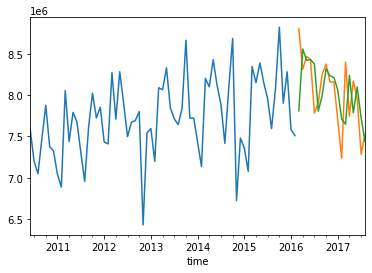

In [217]:
y_pred.index = test_total.index

train_total.plot()
test_total.plot()
y_pred.plot()

In [218]:
print_metrics(test_total, y_pred)

MAE: 309540.4540905545
RMSE: 410083.8235307202
SMAPE: 0.038743504006111415


### Linear Regression

### Gradient Boosting

### Cross-Validation Strategies

## Hierarchical Time Series Models